# Ridership Share: Frequent Network as % of Total CTA Bus Ridership

This notebook tracks what fraction of total CTA bus ridership flows through Frequent Network (FN) routes over time. Unlike the DiD analysis in notebooks 01/03, this is a simple descriptive measure: **are FN routes capturing a bigger slice of the pie?**

| Phase | Launch Date | Routes | Post-data available? |
|-------|------------|--------|---------------------|
| 1 | Mar 23, 2025 | J14, 34, 47, 54, 60, 63, 79, 95 | ~8 months |
| 2 | Summer 2025 | 4, 49, 53, 66 | ~5 months |
| 3 | Fall 2025 | 20, 55, 77, 82 | ~2 months |
| 4 | Dec 21, 2025 | 9, 12, 72, 81 | NONE (data ends Nov 30) |

**Note:** SODA ridership data currently ends Nov 30, 2025. Phase 4 routes have no post-launch data. Phase 2/3 launch dates are approximate.

In [1]:
from datetime import date

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from bus_check.config import ALL_FREQUENT_ROUTES, FREQUENT_NETWORK_PHASES
from bus_check.data.ridership import fetch_all_routes

sns.set_theme(style="whitegrid")
PHASE_COLORS = {1: "#1b9e77", 2: "#d95f02", 3: "#7570b3", 4: "#e7298a"}

In [2]:
# Fetch all-route ridership from SODA API
today_str = date.today().isoformat()
df = fetch_all_routes(start_date="2023-01-01", end_date=today_str)

print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Unique routes: {df['route'].nunique()}")
print(f"FN routes in data: {df[df['route'].isin(ALL_FREQUENT_ROUTES)]['route'].nunique()} / {len(ALL_FREQUENT_ROUTES)}")

Shape: (122084, 4)
Date range: 2023-01-01 to 2025-11-30
Unique routes: 131
FN routes in data: 20 / 20


In [3]:
# Monthly aggregation + share computation
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()
df["is_fn"] = df["route"].isin(ALL_FREQUENT_ROUTES)

# Total rides per month (all routes)
total_monthly = df.groupby("month")["rides"].sum().rename("total_rides")

# FN rides per month (all 20 FN routes)
fn_monthly = df[df["is_fn"]].groupby("month")["rides"].sum().rename("fn_rides")

# Per-phase cumulative route sets
phase_route_sets = {}
cumulative = []
for p in FREQUENT_NETWORK_PHASES:
    cumulative = cumulative + p.routes
    phase_route_sets[p.phase] = list(cumulative)

# Build share DataFrame
share_df = pd.DataFrame({"total_rides": total_monthly, "fn_rides": fn_monthly}).fillna(0)
share_df["share"] = share_df["fn_rides"] / share_df["total_rides"]

for phase_num, routes in phase_route_sets.items():
    col = f"share_p{''.join(str(i) for i in range(1, phase_num + 1))}"
    phase_rides = df[df["route"].isin(routes)].groupby("month")["rides"].sum()
    share_df[col] = phase_rides / share_df["total_rides"]

share_df = share_df.reset_index()
print(f"Monthly share data: {len(share_df)} months")
share_df.tail()

Monthly share data: 35 months


,month,total_rides,fn_rides,share,share_p1,share_p12,share_p123,share_p1234
30,2025-07-01,15291588,5663534,0.370369,0.115170,0.212462,0.291266,0.370369
31,2025-08-01,16098703,6081462,0.377761,0.118554,0.216519,0.298232,0.377761
32,2025-09-01,16572418,6251388,0.377216,0.118911,0.214289,0.300342,0.377216
33,2025-10-01,17026291,6361483,0.373627,0.118729,0.211531,0.297222,0.373627
34,2025-11-01,14175349,5391729,0.380360,0.120001,0.214716,0.302110,0.380360


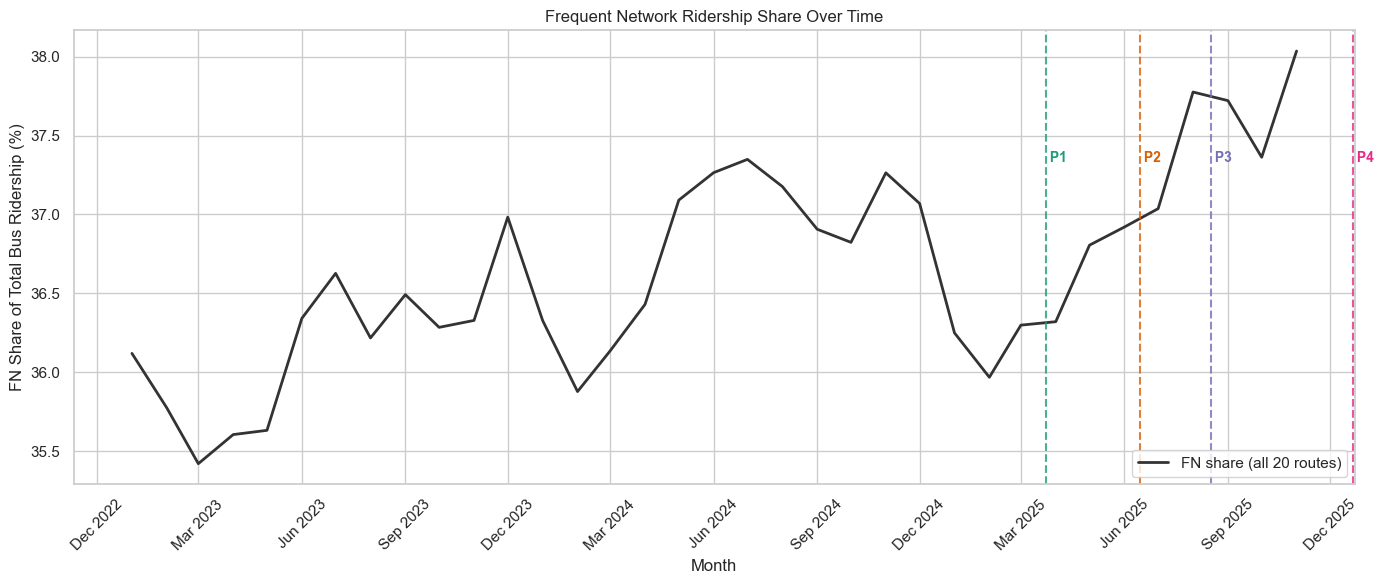

In [4]:
# Share time series with phase markers
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(share_df["month"], share_df["share"] * 100, color="#333333", linewidth=2, label="FN share (all 20 routes)")

for p in FREQUENT_NETWORK_PHASES:
    ax.axvline(pd.Timestamp(p.launch_date), color=PHASE_COLORS[p.phase], linestyle="--", alpha=0.8, linewidth=1.5)
    ax.text(pd.Timestamp(p.launch_date), ax.get_ylim()[1] * 0.98, f" P{p.phase}",
            color=PHASE_COLORS[p.phase], fontsize=10, fontweight="bold", va="top")

ax.set_xlabel("Month")
ax.set_ylabel("FN Share of Total Bus Ridership (%)")
ax.set_title("Frequent Network Ridership Share Over Time")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

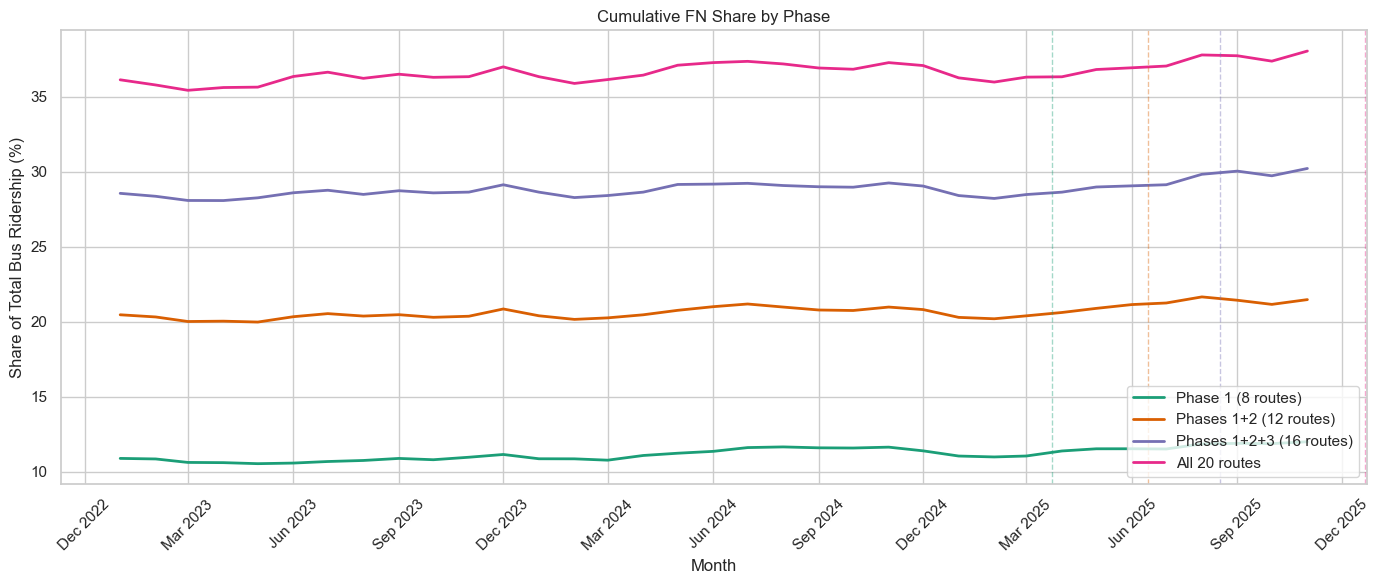

In [5]:
# Per-phase cumulative share lines
fig, ax = plt.subplots(figsize=(14, 6))

phase_share_cols = {
    1: ("share_p1", "Phase 1 (8 routes)"),
    2: ("share_p12", "Phases 1+2 (12 routes)"),
    3: ("share_p123", "Phases 1+2+3 (16 routes)"),
    4: ("share_p1234", "All 20 routes"),
}

for phase_num, (col, label) in phase_share_cols.items():
    if col in share_df.columns:
        ax.plot(share_df["month"], share_df[col] * 100,
                color=PHASE_COLORS[phase_num], linewidth=2, label=label)

for p in FREQUENT_NETWORK_PHASES:
    ax.axvline(pd.Timestamp(p.launch_date), color=PHASE_COLORS[p.phase],
               linestyle="--", alpha=0.4, linewidth=1)

ax.set_xlabel("Month")
ax.set_ylabel("Share of Total Bus Ridership (%)")
ax.set_title("Cumulative FN Share by Phase")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [6]:
# Pre/post comparison table (3-month windows)
from dateutil.relativedelta import relativedelta

results = []
for p in FREQUENT_NETWORK_PHASES:
    launch = pd.Timestamp(p.launch_date)
    routes = phase_route_sets[p.phase]  # cumulative routes through this phase

    # 3-month windows
    pre_start = launch - pd.DateOffset(months=3)
    post_end = launch + pd.DateOffset(months=3)

    pre_mask = (share_df["month"] >= pre_start) & (share_df["month"] < launch)
    post_mask = (share_df["month"] >= launch) & (share_df["month"] < post_end)

    col = f"share_p{''.join(str(i) for i in range(1, p.phase + 1))}"

    pre_share = share_df.loc[pre_mask, col].mean() if pre_mask.any() else None
    post_share = share_df.loc[post_mask, col].mean() if post_mask.any() else None

    # YoY: same calendar months, prior year
    if post_mask.any():
        post_months = share_df.loc[post_mask, "month"]
        yoy_months = post_months - pd.DateOffset(years=1)
        yoy_mask = share_df["month"].isin(yoy_months)
        yoy_share = share_df.loc[yoy_mask, col].mean() if yoy_mask.any() else None
    else:
        yoy_share = None

    delta_pp = (post_share - pre_share) * 100 if (pre_share is not None and post_share is not None) else None
    yoy_delta_pp = (post_share - yoy_share) * 100 if (yoy_share is not None and post_share is not None) else None

    n_post = post_mask.sum()

    results.append({
        "Phase": p.phase,
        "Launch": p.launch_date,
        "Routes (cumul.)": len(routes),
        "Pre share (%)": f"{pre_share * 100:.1f}" if pre_share is not None else "N/A",
        "Post share (%)": f"{post_share * 100:.1f}" if post_share is not None else "N/A",
        "Delta (pp)": f"{delta_pp:+.2f}" if delta_pp is not None else "N/A",
        "YoY prior share (%)": f"{yoy_share * 100:.1f}" if yoy_share is not None else "N/A",
        "YoY delta (pp)": f"{yoy_delta_pp:+.2f}" if yoy_delta_pp is not None else "N/A",
        "Post months": n_post,
    })

comparison_df = pd.DataFrame(results)
print("Pre/post share comparison (3-month windows):")
print("Delta (pp) = post share minus pre share, in percentage points")
print("YoY delta (pp) = post share minus same-calendar-month share from prior year")
print()
comparison_df

Pre/post share comparison (3-month windows):
Delta (pp) = post share minus pre share, in percentage points
YoY delta (pp) = post share minus same-calendar-month share from prior year



,Phase,Launch,Routes (cumul.),Pre share (%),Post share (%),Delta (pp),YoY prior share (%),YoY delta (pp),Post months
0,1,2025-03-23,8,11.0,11.5,+0.45,11.2,+0.26,3
1,2,2025-06-15,12,20.9,21.4,+0.56,21.0,+0.46,3
2,3,2025-08-17,16,29.3,30.0,+0.65,29.1,+0.92,3
3,4,2025-12-21,20,37.7,N/A,N/A,N/A,N/A,0


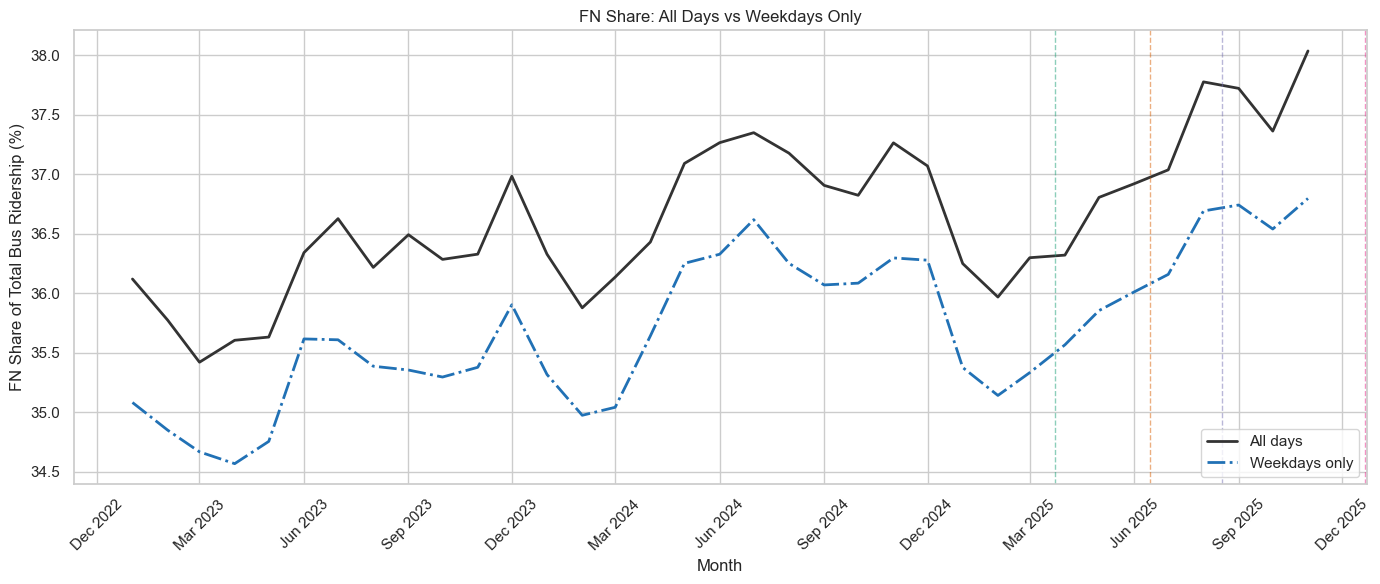

In [7]:
# Weekday-only sensitivity
df_wd = df[df["daytype"] == "W"].copy()

total_wd = df_wd.groupby("month")["rides"].sum()
fn_wd = df_wd[df_wd["is_fn"]].groupby("month")["rides"].sum()
share_wd = (fn_wd / total_wd).rename("weekday_share")

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(share_df["month"], share_df["share"] * 100,
        color="#333333", linewidth=2, label="All days")
ax.plot(share_wd.index, share_wd.values * 100,
        color="#2171b5", linewidth=2, linestyle="-.", label="Weekdays only")

for p in FREQUENT_NETWORK_PHASES:
    ax.axvline(pd.Timestamp(p.launch_date), color=PHASE_COLORS[p.phase],
               linestyle="--", alpha=0.5, linewidth=1)

ax.set_xlabel("Month")
ax.set_ylabel("FN Share of Total Bus Ridership (%)")
ax.set_title("FN Share: All Days vs Weekdays Only")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Summary

**Key findings:**
- See the pre/post table above for percentage-point share changes by phase.
- Phase 1 has the longest post-launch window (~8 months) and is the strongest signal.
- Phase 4 (Dec 21, 2025) has no post-data since SODA ridership ends Nov 30, 2025.

**Limitations:**
- Phase 2 and 3 launch dates are approximate ("Summer 2025" and "Fall 2025").
- Share changes reflect both FN ridership changes AND system-wide trends.
- Weekday vs all-day comparison helps isolate the FN service-window effect, but doesn't control for other confounders.
- This is a descriptive measure, not causal. See notebooks 01/03 for DiD estimates.